# Day 15 Visualising amazon rivers

In [8]:
from pathlib import Path
import rasterio
from rasterio.plot import show, show_hist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = Path('../data/rivers_amazon_data/ndwi_test/')
image_k_means = path.joinpath('k_means_ndwi.tif')
image_rivers = path.joinpath('rivers.tif')

In [3]:
with rasterio.open(image_k_means) as src:
    im = src.read()
    meta = src.meta

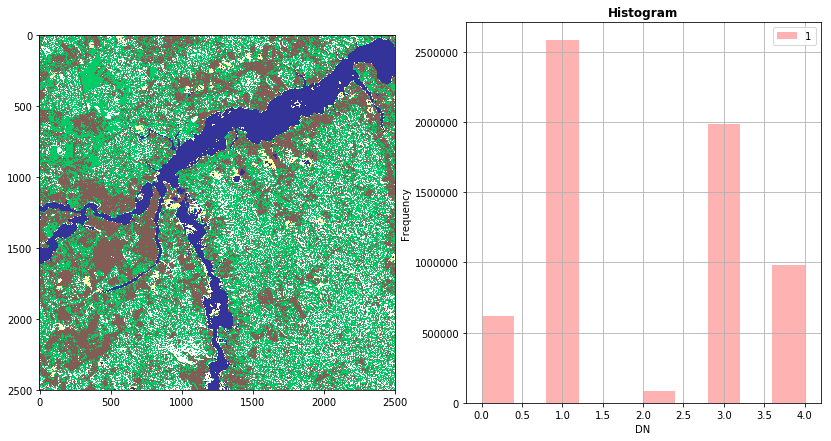

In [4]:
fig, (axim, axhist) = plt.subplots(1,2,figsize=(14,7))
show(im, ax=axim, cmap='terrain')
show_hist(im, alpha=0.3, histtype='stepfilled', ax=axhist)
plt.show()

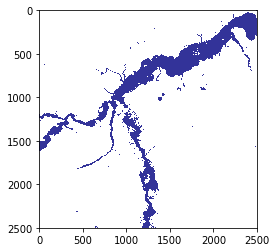

In [5]:
rivers = np.where(im>0, np.nan, im); show(rivers, cmap='terrain');

In [6]:
rivers.dtype

dtype('float64')

`dtype_ranges = {
    'int8': (-128, 127),
    'uint8': (0, 255),
    'uint16': (0, 65535),
    'int16': (-32768, 32767),
    'uint32': (0, 4294967295),
    'int32': (-2147483648, 2147483647),
    'float32': (-3.4028235e+38, 3.4028235e+38),
    'float64': (-1.7976931348623157e+308, 1.7976931348623157e+308)}`
source: https://github.com/mapbox/rasterio/blob/master/examples/reproject.py

In [7]:
meta.update({'dtype': 'float64'})
with rio.open(image_rivers, 'w', **meta) as dst:
    dst.write(rivers)

### Polygonize and visualize

Now to create a polygon of rivers. Using gdal_polygonize.py I used the command line in the folder where the amazon river data exists.
```
gdal_polygonize.py rivers.tif -f "ESRI Shapefile" rivers.shp

gdal_polygonize.py k_means_ndwi.tif -f "ESRI Shapefile" k_means_ndwi.shp
```
This process took about 10minutes. 

Notes: I tried visualisation in folium without much luck with raster. Folium default crs is epsg 3857 (Web Mercator) and when loading my raster using ImageOverlay the result was a grey box, in the correct location, so not 100% satisfying. QGIS provided much nicer for visualisation and I decided that unless I am building a webmap the folium work is not necessary. TaDa! Success in backing out of an interesting rabbit hole!

### Raster reprojection
source of code: https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/interactive-maps/ and rasterio reprojection readme and Sean Gillies readthedocs https://buildmedia.readthedocs.org/media/pdf/rasterio/stable/rasterio.pdf page 68 

Reproject the raster dataset for folium webtiles in WGS84

In [10]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Create variables for destination coordinate system and the name of the projected raster
dst_crs = 'EPSG:3857' 
out_path = path.joinpath('reproj_rivers_full.tif')


# Use rasterio package as rio to open and project the raster
with rio.open(image_k_means) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
 

    # Use rasterio package as rio to write out the new projected raster
    # Code uses loop to account for multi-band rasters
    with rio.open(out_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
            source=rio.band(src, i),
            destination=rio.band(dst, i),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)